# Show usage of CaltechDATA

In [1]:
#Get metadata from CaltechDATA

import os
from ames.harvesters import get_caltechdata

if os.path.isdir('data') == False:
    os.mkdir('data')
os.chdir('data')

production = True
collection = 'caltechdata.ds'

get_caltechdata(collection,production)

100% (1001 of 1001) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


Gathering data!


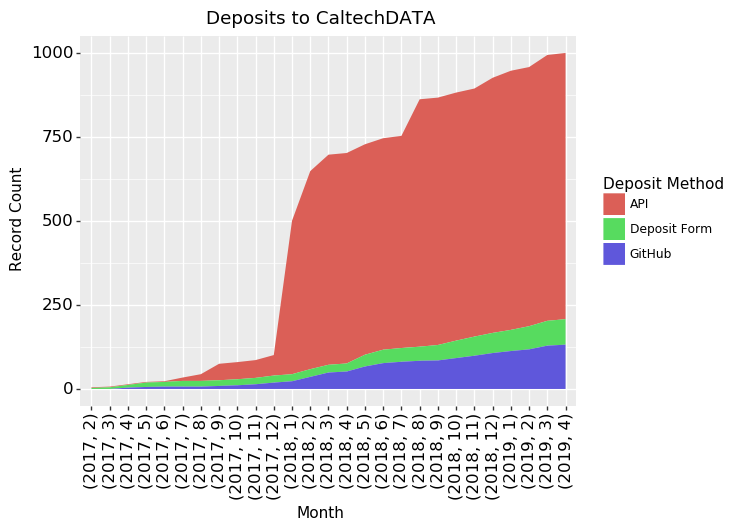

In [7]:
#Collect submissions over time
%matplotlib inline
from ames.harvesters import get_records
import dataset
import pandas as pd
import numpy as np
import plotnine as p9
import warnings
#Plotnine has warning - ignore
warnings.filterwarnings('ignore')

dot_paths = ['._Key','.dates','.resourceType','.subjects','.publicationYear','.contributors']
keys = dataset.keys(collection)
all_metadata = get_records(dot_paths,'dois',collection,keys)
dates = []
categories = []
keys = []
for record in all_metadata:
    #Submitted date type takes precedence, otherwise Updated date (old geo theses)
    rdate = None
    for date in record['dates']:
        if date['dateType']=='Submitted':
            rdate = date['date']
        if date['dateType']=='Updated':
            if rdate == None:
                rdate = date['date']
    dates.append(rdate)
    #We categorize records based on submission type
    category = 'Deposit Form'
    thesis = False
    if 'subjects' in record:
        for s in record['subjects']:
            if 'TCCON' in s['subject']:
                category = 'API'
            if 'Bitbucket' in s['subject']:
                category = 'API'
            if 'Github' in s['subject']:
                category = 'GitHub'
            if 'GitHub' in s['subject']:
                category = 'GitHub'
            if 'thesis' in s['subject']:
                thesis=True
    #Check if Tony handled the thesis record
    if thesis == True:
        if 'contributors' in record:
            for c in record['contributors']:
                if c['contributorName'] == 'Diaz, Tony':
                    category = 'API'
    categories.append(category)
    keys.append(record['_Key'])
data = {'dates':dates,'categories':categories,'keys':keys}
df = pd.DataFrame(data=data)
pd.options.display.max_rows = 2000
#display(df)
df = df.astype({'dates':'datetime64'})
#Group by year, month, and category
df = df.groupby([df["dates"].dt.year, df["dates"].dt.month,df['categories']])['dates'].count()
#Fill in categories with 0 if no values that month
df = df.reindex(pd.MultiIndex.from_product([df.index.levels[0],df.index.levels[1],['API','Deposit Form','GitHub']]),fill_value=0)
#Calculate cumulative sum of categories
df = df.groupby(level=2).cumsum()
#Pull out categories
df = df.reset_index(level=2)
#display(df)
#Cut out future dates with no changes
df = df.loc[(2017,2):(2019,4)]

theme = p9.theme(axis_text_x = p9.element_text(color="black", size=12,
                                                         angle=90),
                           axis_text_y = p9.element_text(color="black", size=12))

plot = p9.ggplot(df, p9.aes(x='dates.index',y='dates',group='level_2',fill='level_2')) + p9.geom_area() + theme + p9.labs(x= 'Month',y= 'Record Count',fill='Deposit Method',title="Deposits to CaltechDATA")
plot.draw()
plot.save('data_plot.png')

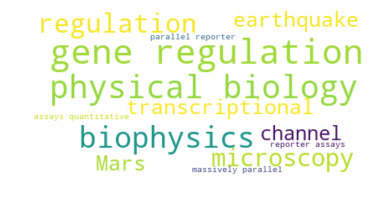

In [8]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

tdict = {}
text = ''
for record in all_metadata:
    if record['resourceType']['resourceTypeGeneral']=='Dataset':
        keep=True
        for s in record['subjects']:
            if 'TCCON' in s['subject']:
                keep=False
        if keep==True:
            for s in record['subjects']:
                subject = s['subject']
                text = text + ' ' + subject
                if subject in tdict:
                    tdict[subject] +=1
                else:
                    tdict[subject] = 1

#print(sorted(tdict.items(), key=lambda kv: kv[1]))
wordcloud = WordCloud(min_font_size=10, max_words=100, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()